# Does this wine taste okay to you?

## Abstract

Wine: a hobby, a pasttime, a way of life, or simply a way to unwind after a day.  While it can be argued that quality of wine can be a subjective field, Sommeliers and data might tell you otherwise.  

This project notebook was created to help those without the heightened senses of the world's wine experts better choose a worthy wine for the occassion.  This is done by exploring 4 different data modeling techniques, partly for show, and partly to see if one has a discernable edge over the others.  

## Introduction

This data is the red wine dataset provided by UCI and hosted at https://archive.ics.uci.edu/ml/datasets/wine+quality

We are interested in red wine, as I felt that red wine pairs better for more occasions than does white.  

## Motivation

Before data-science, the only way to pick an outstanding wine off the shelf was to become a sommelier.  To receive that level of training is at minimum a two day and $700 commitment.  While after training you may have the knowledge of what makes a wine good, you still have to test manually, sip after sip, bottle after bottle.  

While I don't discount the cultured status of someone who completes this level of training, this project aims to enable people to circumvent such a burden.  

## Exploratory Data Analysis
* This first cell imports a few key libraries and the data.
    * We also read the first 5 rows to get a glimpse at the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import project_utils

data_source = (r"winequality-red.csv")

data = pd.read_csv(data_source)

data.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [2]:
data.isnull().sum() 
# Check for null data, 
# If null, employ SimpleImputer
# This set is good to go

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [3]:
data.describe() # Snapshot of general statistics

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

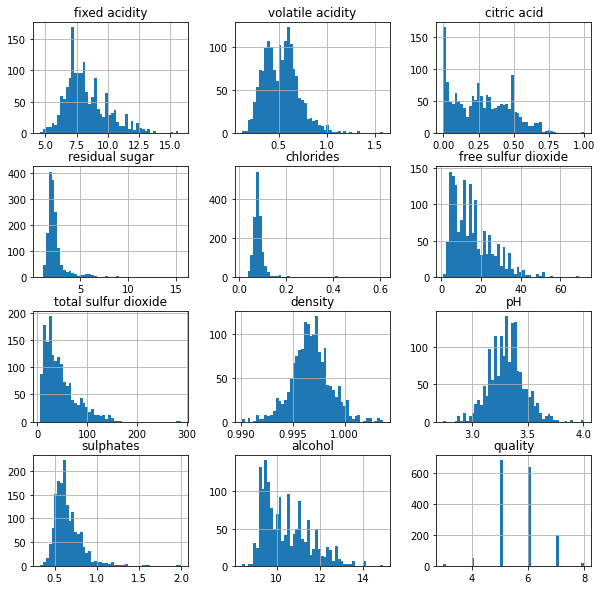

In [4]:
%matplotlib inline

data.hist(bins=50, figsize=(10,10))
plt.show()

# Get initial view of each column/feature, are there consisten distributions?

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


<AxesSubplot:>

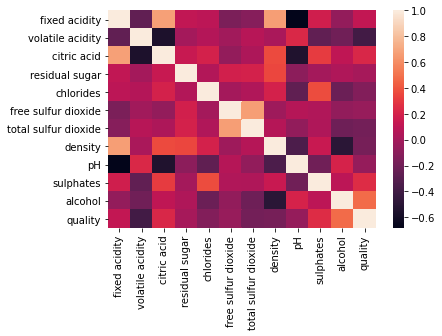

In [5]:
corr_matrix = data.corr()

print(corr_matrix['quality'].sort_values(ascending=False))

sns.heatmap(corr_matrix)

# Let's see if we have any obvious relationships from the whole set
# The strongest correlations are: alcohol, volatile acidity sulphates, and citric acid

### Investigate the stronger correlations

#### Classification and Quality Bins
Because this is a classifcation project, let's set up our quality feature to reflect it.
We are going to create a copy of our dataset as data_bins

In [6]:
# We see a few shapes in the data that might hinder clean visual detail
# This cell aims to chunk some of the more divisive features so we can visualize
# relationships a little easier

data_bins = data.copy()
# Will create a few bins to give a cleaner view

bins = (2, 6, 8)
rating = ['bad', 'good']
data_bins['quality_bins'] = pd.cut(data_bins['quality'], bins = bins, labels = rating)


data_bins['volatile_bins'] = pd.cut(data_bins['volatile acidity'],
                              bins = [.25, .5, .75, 1,  np.inf],
                              labels=[.25, .5, .75, 1])

data_bins['sulphate_bins'] = pd.cut(data_bins['sulphates'],
                              bins=[.25, .5, .75, 1, 1.25, np.inf],
                              labels=[.25, .5, .75, 1, 1.25])

data_bins['alcohol_bins']=pd.cut(data_bins['alcohol'],
                           bins=[9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, np.inf],
                           labels=[9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13])

data_bins['citric_bins'] = pd.cut(data_bins['citric acid'],
                            bins = [0, .1, .2, .3, .4, .5, .6, .7, np.inf],
                            labels=[0, .1, .2, .3, .4, .5, .6, .7, ])

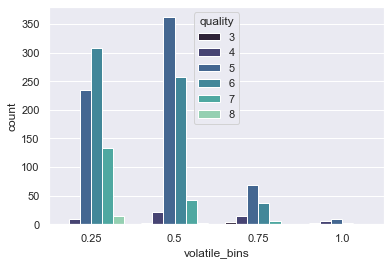

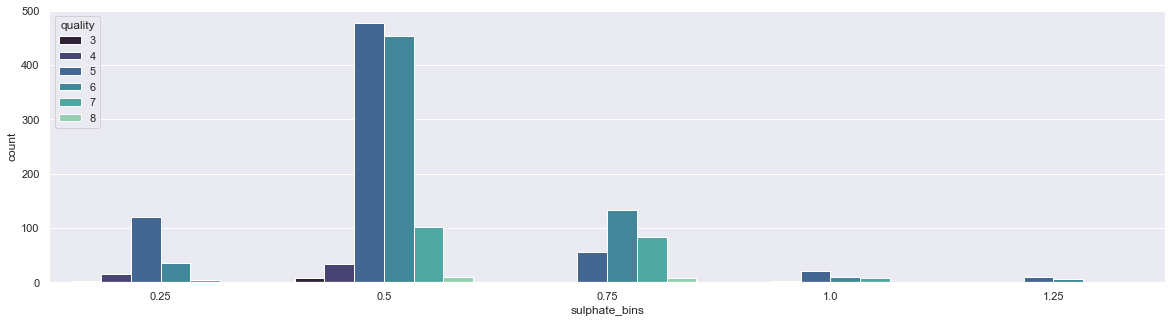

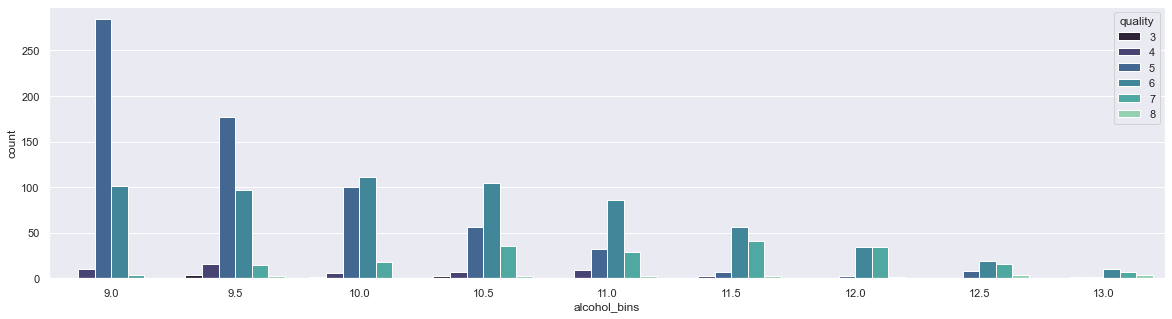

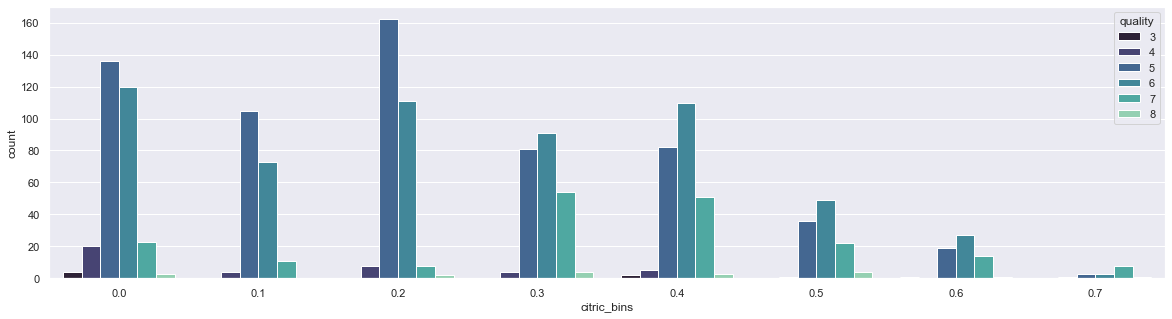

In [7]:
hue = data_bins['quality']

plot_data = data_bins[['volatile_bins','sulphate_bins', 
                       'alcohol_bins', 'citric_bins']]

project_utils.data_plot(hue, plot_data)

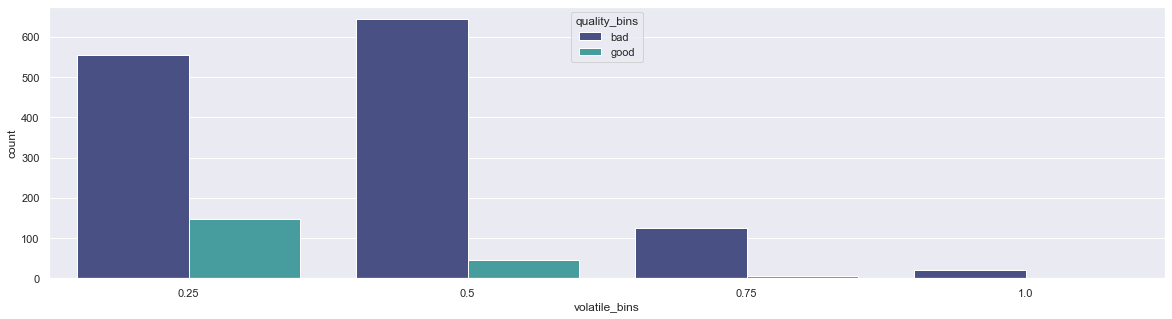

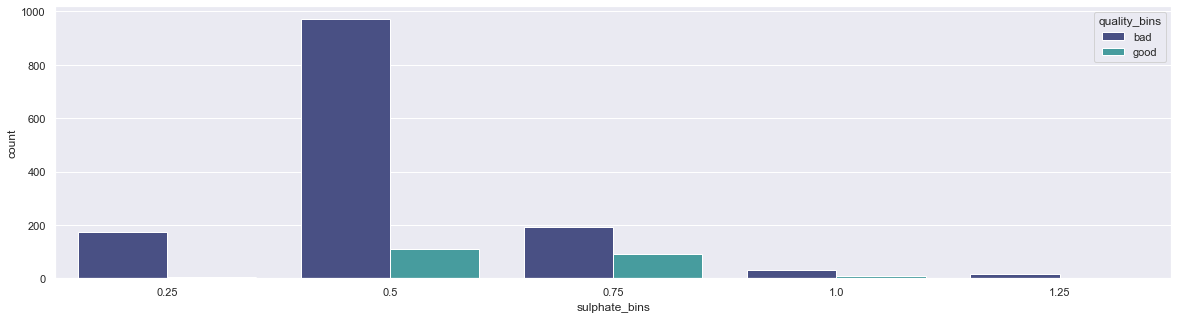

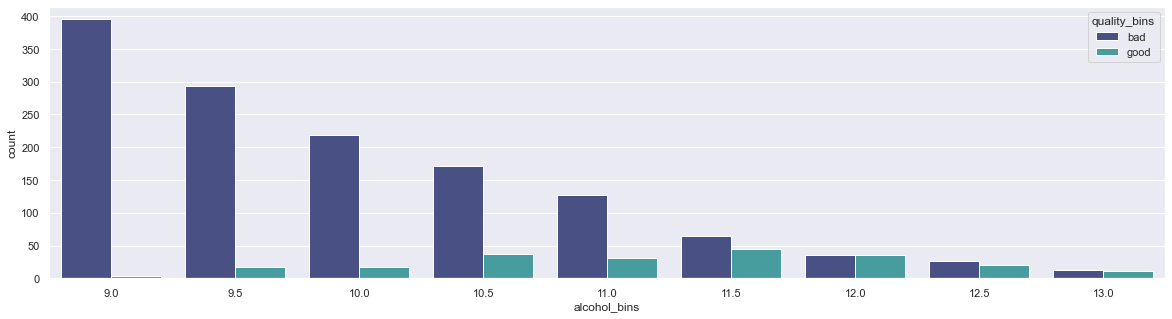

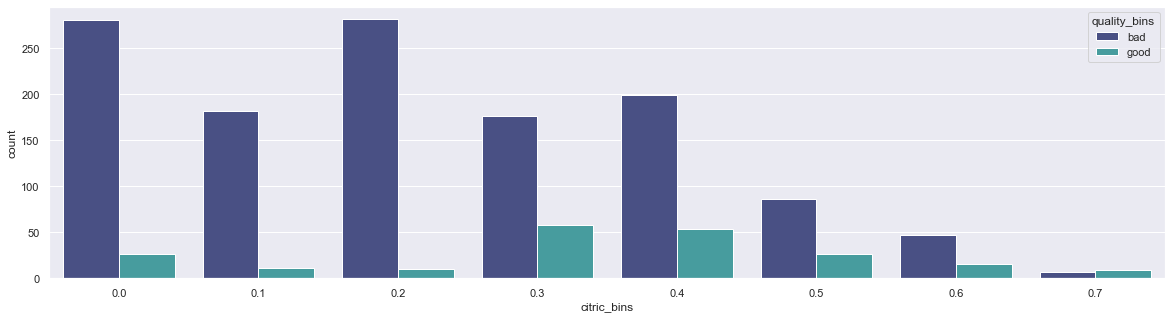

In [8]:
# Going with the binary quality feature we get a very clear idea what features
# are more common to good quality wines

hue = data_bins['quality_bins']
plot_data = data_bins[['volatile_bins','sulphate_bins', 
                       'alcohol_bins', 'citric_bins']]

project_utils.data_plot(hue, plot_data)

## Proposed Method
I play on using 4 distinct modeling methods
* Decision Tree Modeling
* Gradient Descent Classifier
* Logistic Regression
* Random Forest

### Modeling
We need to create a binary out of our quality feature. Below is a callback to out original dataframe, data.  We see that  we have no ratings under 3, so let us create our bins to reflect sucha layout.    

In [29]:
data['quality'].value_counts().sort_values(ascending=False)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [30]:
#Create another copy and reintroduce the binary classifier for quality features
# Ratings between 2 and under 7 account for BAD ratings, all others are good
wine = data.copy()
bins = (2, 6, 8)
rating = ['bad', 'good']

wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = rating)

In [31]:
# Encodes our binary system with numeric values.  This can be scaled with larger sets
# A simple iterative statement could have done this task as well, however this is
# good practice for the tools at hand

from sklearn.preprocessing import LabelEncoder

wine_labeler = LabelEncoder()

wine['quality'] = wine_labeler.fit_transform(wine['quality'])

wine['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [11]:
# Create our training and testing sets

from sklearn.model_selection import train_test_split

X = wine.drop('quality', axis=1)
y = wine['quality']

# Set sizes are 70% training 30% testing
# Random state set to 42 for reproducability.  Also a nod to hitchhikers guide
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   random_state = 42)

#Showing the shape of our 4 data sets 
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

# StandardScaler to standardize features to scale to unit variance.
# We noted a few features that did not display normal distribution of properties

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

X_train shape:  (1119, 11)
y_train shape:  (1119,)
X_test shape:  (480, 11)
y_test shape:  (480,)


In [32]:
# PCA will be utilized to find principled axes in the data, and then allowing us to
# better visualize our models performance

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Decision Tree Modeling

Results of DecisionTreeClassifier(criterion='entropy', random_state=42) Model: 

Accuracy of model 0.8229

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       413
           1       0.39      0.46      0.42        67

    accuracy                           0.82       480
   macro avg       0.65      0.67      0.66       480
weighted avg       0.84      0.82      0.83       480


Confusion Matrix:
[[364  49]
 [ 36  31]]



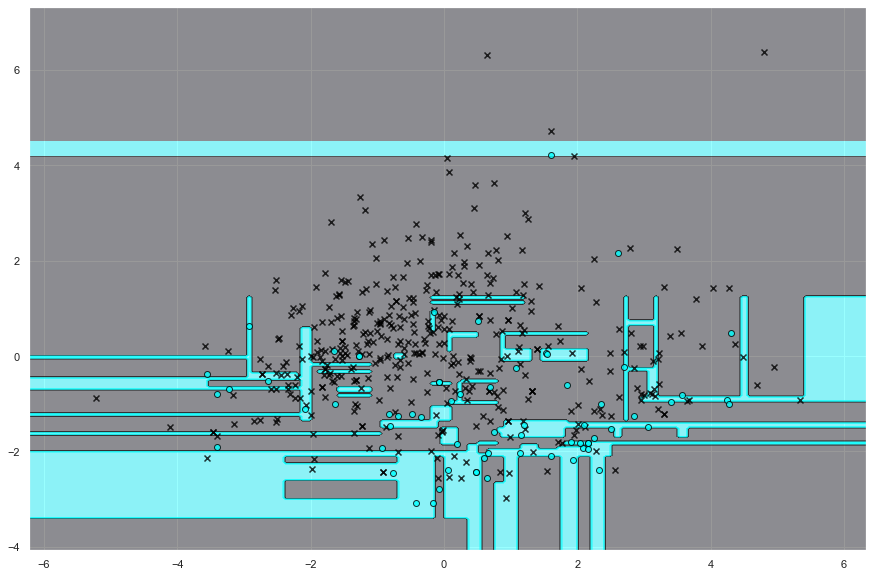

In [13]:
from sklearn.tree import DecisionTreeClassifier as DT

dt_model = DT(criterion='entropy', random_state=42)
dt_model.fit(X_train, y_train)

project_utils.print_results(dt_model, X_test, y_test)

project_utils.visual_model('Decision Tree Modeling', X_test, y_test, dt_model)

#### Gradient Descent Classifier

Results of SGDClassifier(penalty=None) Model: 

Accuracy of model 0.8354

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       413
           1       0.34      0.19      0.25        67

    accuracy                           0.84       480
   macro avg       0.61      0.57      0.58       480
weighted avg       0.80      0.84      0.82       480


Confusion Matrix:
[[388  25]
 [ 54  13]]



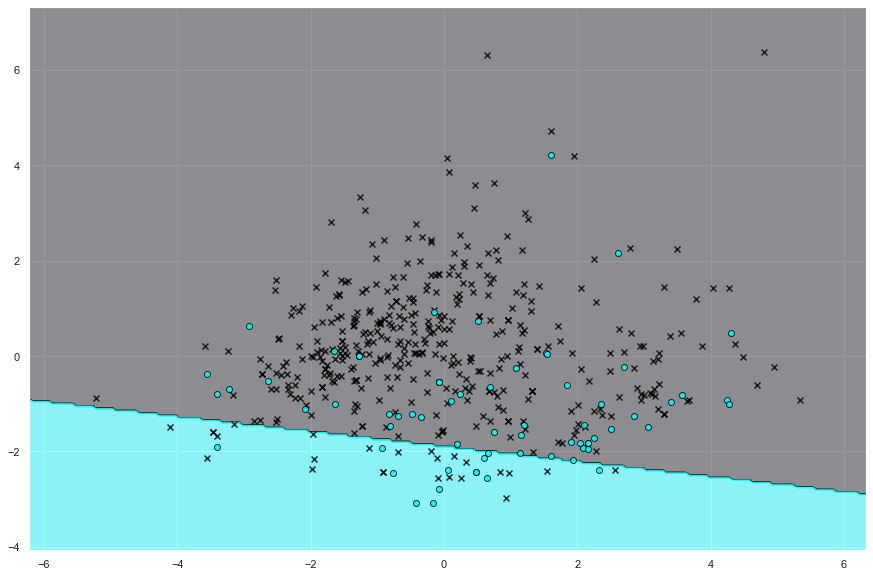

In [14]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

project_utils.print_results(sgd, X_test, y_test)

project_utils.visual_model('Gradient Descent', X_test, y_test, sgd)

#### Logistic Regression

Results of LogisticRegression() Model: 

Accuracy of model 0.8583

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       413
           1       0.47      0.10      0.17        67

    accuracy                           0.86       480
   macro avg       0.67      0.54      0.55       480
weighted avg       0.81      0.86      0.82       480


Confusion Matrix:
[[405   8]
 [ 60   7]]



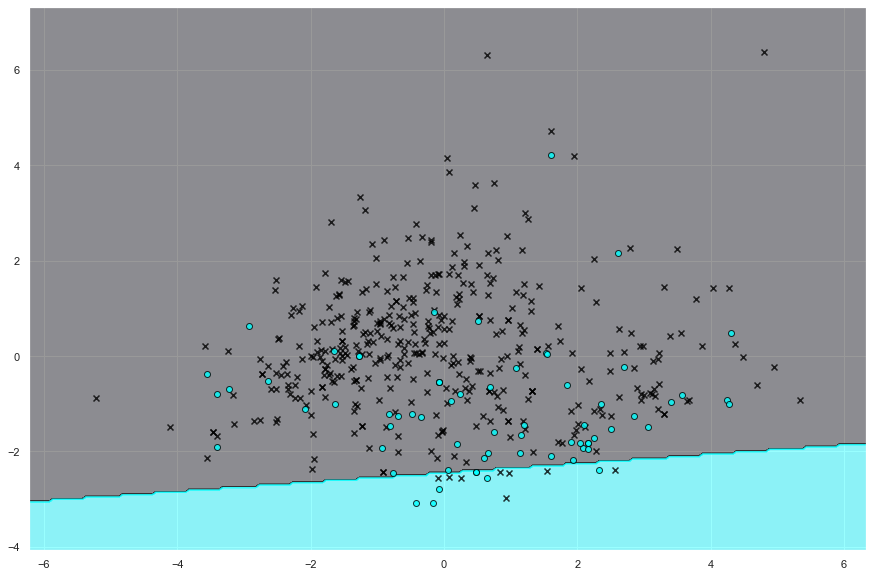

In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

project_utils.print_results(logreg, X_test, y_test)

project_utils.visual_model('Logistic Regression', X_test, y_test, logreg)

#### Random Forest

Results of RandomForestClassifier(n_estimators=200) Model: 

Accuracy of model 0.8625

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       413
           1       0.51      0.36      0.42        67

    accuracy                           0.86       480
   macro avg       0.71      0.65      0.67       480
weighted avg       0.85      0.86      0.85       480


Confusion Matrix:
[[390  23]
 [ 43  24]]



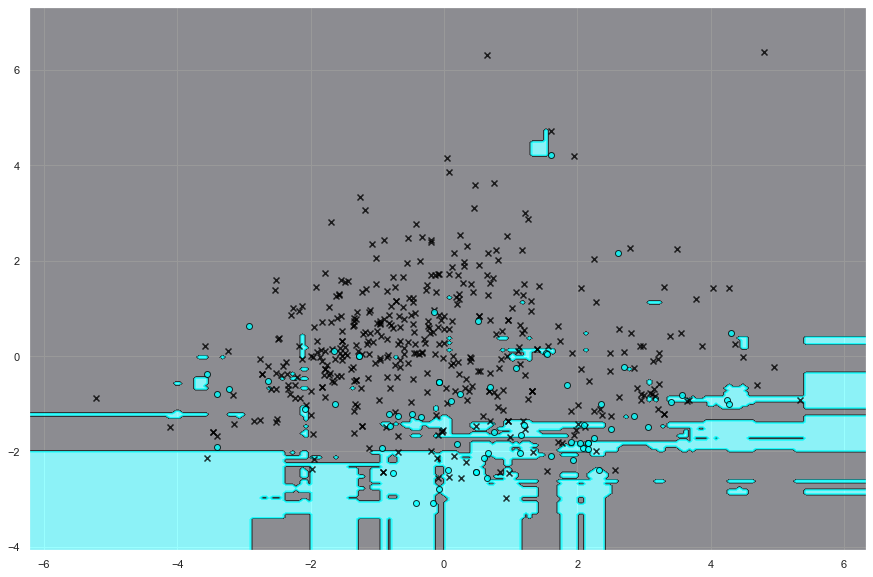

In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)

rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

project_utils.print_results(rfc, X_test, y_test)

project_utils.visual_model('Random Forest', X_test, y_test, rfc)

## Results and discussion
We didn't get much difference between our models.
* Decision Trees bottomed out at 82.29% accuracy
* Random Forest gave us a bit better result at 86.25%, 4% higher

What I do notice from our confusion matrices, as well as our visual models is that, while we can often predict **bad** wines, our models struggle to predict **good** wines. 

You can argue any wine that is *not* a bad wine is a good wine, that's not an ideal call to make.  

## Conclusion and summary

We have a great model for finding wines to ****not pick**** however, we take a small gamble at finding an absolute awful wine (sub 3 quality rating).  

## Limitations and later work

Our data only had ~217 instances of wine that would be labeled **good**, which was not enough to create a strong model for predicting those.  Our highest scoring for good wine was ~51%, again if we took this model to larger sets with potentially awful wine, we run the risk of choosing them as a non-bad wine.  

## References and contributions

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

S. Raschka. Python Machine Learning, Third Edition. 978-1-78355-513-0, 2019

A Geron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition. 978-1492032649, 2019